In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../../../astro_codes/')

In [3]:
samples = Table.read('../matched_fits/samples.fits')
masks = Table.read('../matched_fits/bad_flux_mask.fits')
sfrs = Table.read('../matched_fits/sfr_table.fits')
chang_out_matched = Table.read('../matched_fits/chang_out_matched.fits')
print('Loaded the data')

Loaded the data


In [4]:
# first, define the star-forming sample:

in_sf = (samples['in_vmax_limit']*samples['star_forming']).astype(bool)
ok_flux = (masks['fuv']*masks['w4']).astype(bool)
reference_sample = (in_sf*ok_flux).astype(bool)

print('{} galaxies in vmax, with {} star-forming, and {} with reliable fluxes'.format(np.sum(samples['in_vmax_limit']),
                                                                                      np.sum(in_sf),
                                                                                      np.sum(reference_sample)))

mass = chang_out_matched['lmass50_all']
ssfr = sfrs['total'] - mass
vmax_weight = samples['mass_weighting']

35782 galaxies in vmax, with 14436 star-forming, and 8094 with reliable fluxes


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


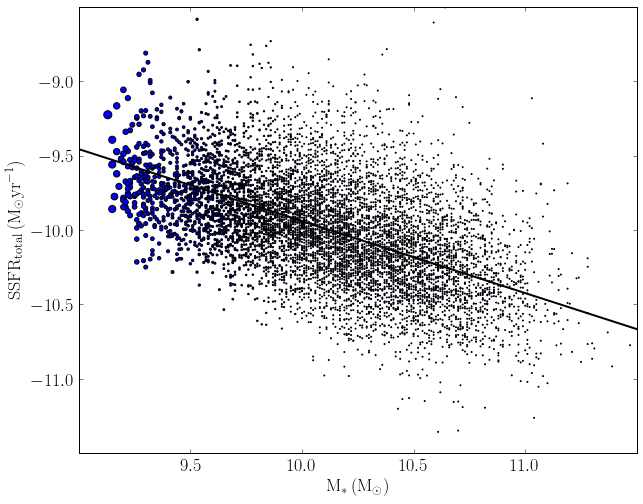

In [5]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*x + c

axis_limits = (9,11.5,-11.5,-8.5)

x = mass[reference_sample]
y = ssfr[reference_sample]
w = vmax_weight[reference_sample]

_ = plt.scatter(x,y,s=w)

p, _ = curve_fit(linear,x,y,sigma=w,absolute_sigma=False)
x_guide = np.linspace(axis_limits[0],axis_limits[1],100)
_ = plt.plot(x_guide,linear(x_guide,*p),color='k',lw=2)

plt.xlabel('$\mathrm{M_* \, (M_\odot)}$')
plt.ylabel('$\mathrm{SSFR_{total} \, (M_\odot yr^{-1})}$')
_ = plt.axis(axis_limits)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype >f8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:271: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)


8094
(8094, 2)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


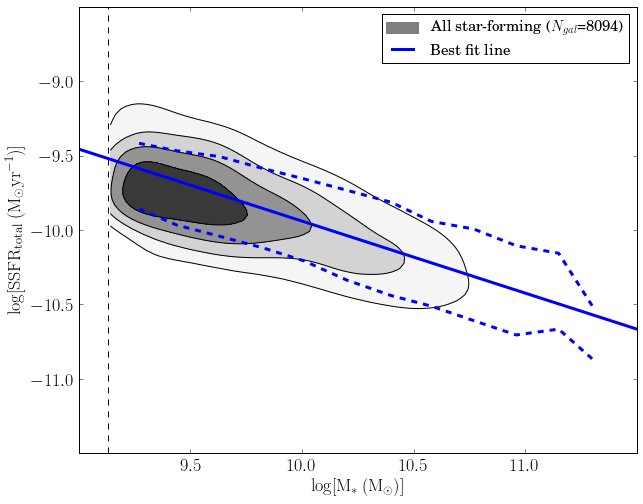

In [6]:
from contours import kde_contour
from line_plotting import get_line

fill_properties = {'alpha':1}
_ = kde_contour(x,y,fill=True,weights=w,fill_properties=fill_properties)
_ = plt.plot([],[],color='k',lw=12,alpha=0.5,
             label='All star-forming ($N_{{gal}}$={})'.format(np.sum(len(x))))

_ = plt.plot(x_guide,linear(x_guide,*p),color='b',lw=3,linestyle='solid'
             ,label='Best fit line')

line_stats, _= get_line(x,y,bins=12,use_bootstrap=True)
_ = plt.plot(line_stats['x'],line_stats['y_upper'],linestyle='dashed',lw=3,color='b')
_ = plt.plot(line_stats['x'],line_stats['y_lower'],linestyle='dashed',lw=3,color='b')

plt.xlabel('$\mathrm{\log[M_* \, (M_\odot)}]$')
plt.ylabel('$\mathrm{\log[SSFR_{total} \, (M_\odot yr^{-1})]}$')
_ = plt.axis(axis_limits)
_ = plt.legend(fontsize=15)

low_mass_limit = np.min(x)
plt.vlines(np.min(x),axis_limits[2],axis_limits[3],color='k',linestyle='dashed')

#_ = plt.savefig('../output_figures/sfms_all.pdf')

In [ ]:
scatter = ssfr[reference_sample] - linear(mass[reference_sample],*p)
_ = plt.hist(scatter,bins=np.linspace(-1.5,1.5,100),normed=True)
print('Median scatter = {}'.format(np.round(np.median(np.abs(scatter)),decimals=2)))

In [ ]:
# now attempt to plot up the 'SF deficiency' for each of the samples?
from matplotlib.ticker import MaxNLocator

def histogram_stack(x,m_x,bins,x_reference=None,
                    plot_percentiles=False,printout=False):
    
    colors = ['orange','r','m','g','b']
    mlabels = ['1','2','3','4','5+']
    flabels = 'abcde'
    
    fig, axarr = plt.subplots(5,1,figsize=(10,15),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    
    for m in range(5):
        in_m = m_x == m
        ax = axarr[m]
        ax.set_ylabel('normalised \n density')
        ax.text(0.025,0.925,'({}) m={} ($N_{{gal}}$={})'.format(flabels[m],
                                                                mlabels[m],
                                                                len(x[in_m])),
                ha='left',va='top',transform=ax.transAxes)

        if x_reference is not None:
            _ = ax.hist(x_reference,bins=bins,normed=True,
                         color='k',alpha=0.4,histtype='stepfilled')
            _ = ax.hist(x_reference,bins=bins,normed=True,
                         color='k',histtype='step')
        
        _ = ax.hist(x[in_m],bins=bins,normed=True,
                    color=colors[m],histtype='step',lw=3)
        
        ylims = ax.set_ylim()
    for m in range(5):
        ax = axarr[m]
        in_m = m_x == m
        x_lower = np.percentile(x[in_m],16)
        x_median = np.median(x[in_m])
        x_upper = np.percentile(x[in_m],84)
        if plot_percentiles == True:
            for x_ in [x_lower,x_median,x_upper]:
                _ = ax.vlines(x_,ylims[0],ylims[1],
                                color=colors[m],lw=3,linestyle='dotted')
        if printout == True:
            print('{}: lower={}, median={}, upper={}'.format(mlabels[m],
                                                             np.round(x_lower,decimals=2),
                                                             np.round(x_median,decimals=2),
                                                             np.round(x_upper,decimals=2)))
                
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8,prune='both'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6,prune='both'))
    
    return fig, axarr

In [ ]:
in_spiral = (samples['in_spiral']*samples['axial_ok']).astype(bool)
in_mass = samples['in_mass_limit']
spiral_sample = (in_mass*in_spiral*ok_flux).astype(bool)

ssfr_expected = linear(mass,*p)

ssfr_spiral = ssfr[spiral_sample]
mass_spiral = mass[spiral_sample]
m_spiral = samples['m'][spiral_sample]
ssfr_norm_spiral = (ssfr-ssfr_expected)[spiral_sample]

fig, axarr = histogram_stack(ssfr_norm_spiral,m_spiral,bins=np.linspace(-1.5,1.5,31)
                    ,x_reference=ssfr_norm_spiral,plot_percentiles=True,printout=True)

axarr[-1].set_xlabel('$\mathrm{SSFR_{total} - SSFR_{expected}}$')

fig.savefig('../output_figures/ssfr_defeciency.pdf')

In [ ]:
fig, axarr = histogram_stack(mass_spiral,m_spiral,bins=np.linspace(10,11.5,32)
                    ,x_reference=mass_spiral,plot_percentiles=True)

axarr[0].set_ylim(0,2)

#axarr[-1].set_xlabel('$\mathrm{SSFR_{total} - SSFR_{expected}}$')
axarr[-1].set_xlabel('$M_*$')